In [46]:
# Setup kaggle, add kaggle.json to colab files.
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [2]:
# Download dataset from kaggle
! kaggle datasets download samaneheslamifar/facial-emotion-expressions

 84% 101M/121M [00:00<00:00, 237MB/s] 
100% 121M/121M [00:00<00:00, 251MB/s]


In [3]:
#Unzip file
! unzip facial-emotion-expressions.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/validation/fear/8797.jpg  
  inflating: images/validation/fear/8818.jpg  
  inflating: images/validation/fear/886.jpg  
  inflating: images/validation/fear/9037.jpg  
  inflating: images/validation/fear/9040.jpg  
  inflating: images/validation/fear/9101.jpg  
  inflating: images/validation/fear/911.jpg  
  inflating: images/validation/fear/9179.jpg  
  inflating: images/validation/fear/9205.jpg  
  inflating: images/validation/fear/9232.jpg  
  inflating: images/validation/fear/9251.jpg  
  inflating: images/validation/fear/9261.jpg  
  inflating: images/validation/fear/9281.jpg  
  inflating: images/validation/fear/9302.jpg  
  inflating: images/validation/fear/9333.jpg  
  inflating: images/validation/fear/9369.jpg  
  inflating: images/validation/fear/9370.jpg  
  inflating: images/validation/fear/9474.jpg  
  inflating: images/validation/fear/949.jpg  
  inflating: images/validation/fear/9602.jpg  
  inflating:

In [47]:
# Imports required for this project [1]
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import glob
import cv2
import os

tf.random.set_seed(23)

In [48]:
# Show image classes [1]
data_dir = '/content/images'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

['images', 'validation', 'train']
Train Classes - ['sad', 'surprise', 'disgust', 'happy', 'neutral', 'fear', 'angry']
Validation Classes - ['sad', 'surprise', 'disgust', 'happy', 'neutral', 'fear', 'angry']


In [49]:
# Creating the Pathlib PATH objects [1]
train_path = Path("/content/images/train")
valid_path = Path("/content/images/validation")

In [50]:
# Define constants (subject to change with testing)[1]
batch_size = 64
epochs = 40
img_channel = 3
img_width, img_height = (48,48)
train_dataset_main = data_dir + "/train"
valid_dataset_main = data_dir + "/validation"

In [51]:
# Prepare datasets [1]
def create_dataset_df(main_path, dataset_name):
    print(f"{dataset_name} is creating ...")
    df = {"img_path":[],"class_names":[]}
    for class_names in os.listdir(main_path):
            for img_path in glob.glob(f"{main_path}/{class_names}/*"):
                df["img_path"].append(img_path)
                df["class_names"].append(class_names)
    df = pd.DataFrame(df)
    print(f"{dataset_name} is created !")
    return df

In [52]:
# [1]
train_df = create_dataset_df(train_dataset_main, "Train dataset")

Train dataset is creating ...
Train dataset is created !


In [53]:
# [1]
valid_df=create_dataset_df(valid_dataset_main, "Validation dataset")

Validation dataset is creating ...
Validation dataset is created !


In [54]:
#  [1]
print(f"train samples: {len(train_df)} \n validation samples: {len(valid_df)}")

train samples: 28821 
 validation samples: 7066


In [55]:
# For vizualization [1]
def vizualizing_images(df,n_rows,n_cols):
    plt.figure(figsize=(10,10))
    for i in range(n_rows*n_cols):
        index = np.random.randint(0, len(df))
        img = cv2.imread(df.img_path[index])
        class_nm = df.class_names[index]
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(img)
        plt.title(class_nm)
    plt.show()

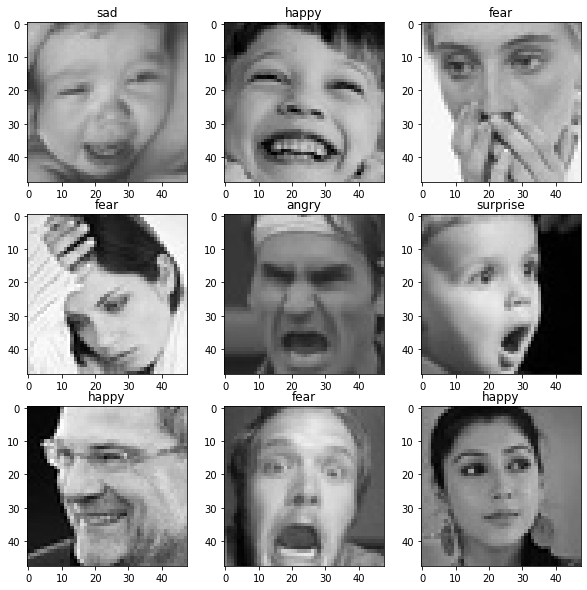

In [56]:
# [1]
vizualizing_images(train_df, 3, 3)

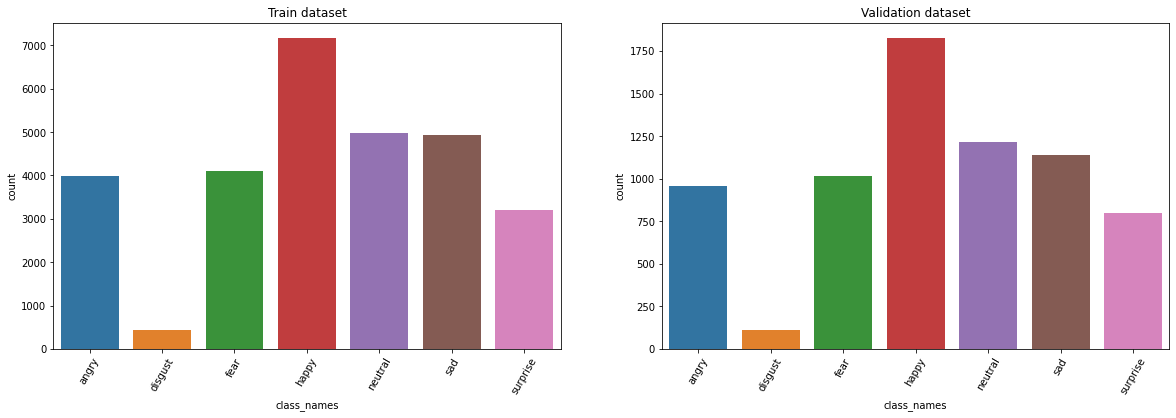

In [57]:
# [1]
plt.figure(figsize=(20,6))
# train dataset
plt.subplot(1,2,1)
sns.countplot(data=train_df.sort_values("class_names"),x="class_names")
plt.title("Train dataset")
plt.xticks(rotation = 60)
# validation dataset
plt.subplot(1,2,2)
sns.countplot(data=valid_df.sort_values("class_names"),x="class_names")
plt.title("Validation dataset")
plt.xticks(rotation = 60)

plt.show()

In [58]:
# [1]
from sklearn.preprocessing import LabelEncoder 

Le = LabelEncoder()
train_df["class_names"] = Le.fit_transform(train_df["class_names"])

train_df["class_names"].value_counts()

3    7164
4    4982
5    4938
2    4103
0    3993
6    3205
1     436
Name: class_names, dtype: int64

In [59]:
# [1]
valid_df["class_names"] = Le.transform(valid_df["class_names"])

In [60]:
#One Hot encoding [1]
train_labels = tf.keras.utils.to_categorical(train_df["class_names"])
valid_labels = tf.keras.utils.to_categorical(valid_df["class_names"])

In [61]:
# [1]
train_labels[:10]

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [62]:
# [1]
train_labels.sum(axis=0)

array([3993.,  436., 4103., 7164., 4982., 4938., 3205.], dtype=float32)

In [63]:
# Compute class weights [1]

classTotals = train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7941397, 1: 16.431192, 2: 1.7460395, 3: 1.0, 4: 1.4379767, 5: 1.4507898, 6: 2.2352574}


In [64]:
# [1]
input_image = cv2.imread(train_df.img_path[0])

input_image.shape

(48, 48, 3)

In [65]:
# Function used for Transformation [1]

def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    return image , label

In [66]:
# Define IMAGE SIZE and BATCH SIZE [1]
IMG_SIZE = 48 
BATCH_SIZE = 64

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)          
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05))
])

In [67]:
# Function used to Create a Tensorflow Data Object [1]
AUTOTUNE = tf.data.experimental.AUTOTUNE #to find a good allocation of its CPU budget across all parameters
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)
        dataset = dataset.repeat()
    
    return dataset

In [68]:
# Creating Train Dataset object and Verifying it [1]
%time  
train_dataset = get_dataset(train_df["img_path"], train_labels)

#iter() returns an iterator of the given object
#next() returns the next number in an iterator
image , label = next(iter(train_dataset)) 
print(image.shape)
print(label.shape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.7 µs


(64, 48, 48, 3)
(64, 7)


sad


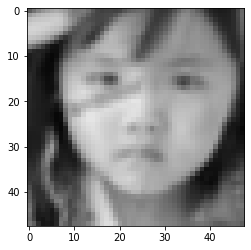

In [69]:
# View a sample Training Image [1]
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(48 , 48 , 3))

In [70]:
# [1]
%time 
val_dataset = get_dataset(valid_df["img_path"] , valid_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
(64, 48, 48, 3)
(64, 7)


sad


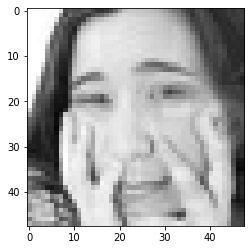

In [71]:
# View a sample Validation Image [1]
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(48 , 48 , 3))

In [96]:
# Building model
import tensorflow as tf
model = tf.keras.Sequential()

  # Layer 1
model.add(tf.keras.layers.Conv2D(64, input_shape=(48,48,3), kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))
# Layer 2
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
model.add(tf.keras.layers.Dropout(0.3))

# Last fully connected layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(7, activation='softmax'))

# Compiling your model by providing the Optimizer , Loss and Metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_107 (Conv2D)         (None, 23, 23, 64)        36928     
                                                                 
 batch_normalization_19 (Bat  (None, 23, 23, 64)       256       
 chNormalization)                                                
                                                     

In [97]:
# [1]
len(train_labels),len(valid_labels)

(28821, 7066)

In [98]:
# [1]
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=3,mode="auto")

In [99]:
# Train the model [1]
#6:30 minutes 1st run, none of epoch's improved accuracy, val acc 0.1345, stopped at epoch 3
#4:10 minutes 2nd run, no improvement, val acc 0.1345, stopped at epoch 3
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_labels)//BATCH_SIZE,
    epochs=12,
    callbacks=[early_stopping],
    validation_data=val_dataset,
    validation_steps = len(valid_labels)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/12
450/450 [==============================] - 45s 86ms/step - loss: 2.0881 - accuracy: 0.7491 - val_loss: 16.0340 - val_accuracy: 0.1349
Epoch 2/12
450/450 [==============================] - 39s 86ms/step - loss: 2.2852 - accuracy: 0.7142 - val_loss: 15.1415 - val_accuracy: 0.1341
Epoch 3/12
450/450 [==============================] - 39s 86ms/step - loss: 2.0776 - accuracy: 0.7132 - val_loss: 10.8173 - val_accuracy: 0.1334
Epoch 4/12
450/450 [==============================] - 39s 86ms/step - loss: 2.1313 - accuracy: 0.6970 - val_loss: 21.6643 - val_accuracy: 0.1348


In [100]:
# [1]
model.layers[0].trainable = False

In [104]:
# Defining our callbacks [1]
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",patience=2)

In [105]:
# [1]
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization_18 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 23, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_107 (Conv2D)         (None, 23, 23, 64)        36928     
                                                                 
 batch_normalization_19 (Bat  (None, 23, 23, 64)       256       
 chNormalization)                                                
                                                     

In [106]:
# 2nd Train the model [1]
#7 min 1st run, only epoch 2 was an improvement, stopped at epoch 4, val accuracy at epoch 2 was 0.1349, best val_loss was 9.87819
#3:10 min 2nd run, no improvement, val acc 0.1349 at epoch 3, best val_loss 9.47477
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_labels)//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps = len(valid_labels)//BATCH_SIZE,
    class_weight=class_weight
)

# References
# [1] https://www.kaggle.com/code/anand1994sp/facial-expression

Epoch 1/8
450/450 [==============================] - ETA: 0s - loss: 2.0136 - accuracy: 0.7113
Epoch 1: val_loss improved from inf to 35.49606, saving model to best_weights.h5
450/450 [==============================] - 37s 83ms/step - loss: 2.0136 - accuracy: 0.7113 - val_loss: 35.4961 - val_accuracy: 0.1338
Epoch 2/8
450/450 [==============================] - ETA: 0s - loss: 1.8491 - accuracy: 0.7249
Epoch 2: val_loss improved from 35.49606 to 24.12968, saving model to best_weights.h5
450/450 [==============================] - 37s 82ms/step - loss: 1.8491 - accuracy: 0.7249 - val_loss: 24.1297 - val_accuracy: 0.1342
Epoch 3/8
449/450 [============================>.] - ETA: 0s - loss: 1.8200 - accuracy: 0.7270
Epoch 3: val_loss improved from 24.12968 to 10.26904, saving model to best_weights.h5
450/450 [==============================] - 37s 82ms/step - loss: 1.8167 - accuracy: 0.7276 - val_loss: 10.2690 - val_accuracy: 0.1378
Epoch 4/8
449/450 [============================>.] - ETA: 0s